In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

In [3]:
import os

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

In [5]:
import importlib

In [6]:
importlib.reload(model)

<module 'model' from '/data/itasarom/diplom/gan_embeddings/GAN/model.py'>

In [7]:
def normalize_embeddings(embeddings):
    EPS = 1e-9
    mean = embeddings[1:].mean(axis=0, keepdims=True)
    se = (embeddings[1:].var(axis=0, keepdims=True)  + EPS )**0.5
#     embeddings
    embeddings = (embeddings - mean)/se
    embeddings[0, :] = 0
    return embeddings

In [9]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='en', max_sent_length=100)
# vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es', max_sent_length=100)
# vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='ru')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='fr', max_sent_length=100)

In [10]:
# vocab1.embeddings.var(axis=0)

In [11]:
vocab1.embeddings = normalize_embeddings(vocab1.embeddings)
vocab2.embeddings = normalize_embeddings(vocab2.embeddings)

In [12]:
# vocab1.embeddings.var(axis=0)

In [13]:
len(vocab1.embeddings), len(vocab2.embeddings)

(50001, 50001)

In [14]:
len(sents1), len(sents2)

(17860, 18641)

In [15]:
torch.cuda.is_available()

True

In [19]:
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels, max_sent_length=None, seed=42)

In [20]:
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels, max_sent_length=None, seed=42)

In [21]:
print(len(sent_sampler_1.sents), len(sent_sampler_2.sents))

17860 18641


In [22]:
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)

In [23]:
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [24]:
import IPython


In [25]:
sent_sampler_1.test[0][111]

['<pad>',
 'colourlovers',
 'viewed',
 'this',
 'page',
 'and',
 'think',
 '<pad>',
 'is',
 'better',
 'than',
 'chocolate',
 'rank',
 'description',
 'bitch',
 'ok',
 'i',
 '<pad>',
 'u',
 'just',
 'called',
 'me',
 'cute',
 'like',
 '<pad>',
 'minutes',
 'ago',
 'but',
 'im',
 '<pad>',
 'u',
 'right',
 'now',
 'boy',
 'u',
 'are',
 'straight',
 'as',
 'fuck',
 'and',
 'u',
 'will',
 'never',
 'have',
 '<pad>',
 'go',
 'through',
 'the',
 'shame',
 'and',
 'terror',
 'and',
 'discomfort',
 'i',
 'have',
 'and',
 'u',
 'will',
 'never',
 'have',
 'to',
 'wonder',
 'if',
 'ur',
 'just',
 'as',
 'real',
 'as',
 'anybody',
 'else',
 'or',
 'why',
 'it',
 'was',
 'u',
 'and',
 'not',
 'the',
 'others',
 'u',
 'wont',
 'so',
 'don',
 't',
 'tell',
 'me',
 'u',
 'think',
 'u',
 'can']

In [26]:
sent_sampler_2.test[0][111]

['le',
 'ministère',
 'du',
 'travail',
 'de',
 'l',
 'emploi',
 'et',
 'de',
 'la',
 'sécurité',
 'sociale',
 'a',
 'annoncé',
 'hier',
 'dans',
 'un',
 'communiqué',
 'que',
 'la',
 'journée',
 'de',
 'mardi',
 '<pad>',
 'novembre',
 '<pad>',
 'sera',
 '<pad>',
 'et',
 'payée',
 'ce',
 'congé',
 'chômé',
 'et',
 'payé',
 'concerne',
 'l',
 'ensemble',
 'des',
 'personnels',
 'des',
 'institutions',
 'et',
 'administrations',
 'publiques',
 'des',
 'services',
 'spécialisés',
 'des',
 'collectivités',
 'locales',
 'et',
 'les',
 'entreprises',
 'commerciales',
 'industrielles',
 'artisanales',
 'et',
 'agricoles',
 'y',
 'compris',
 'les',
 'personnels',
 'payés',
 'à',
 'l',
 'heure',
 'et',
 'à',
 'la',
 'journée',
 'toutefois',
 'les',
 'personnes',
 'exerçant',
 'en',
 'travail',
 'posté',
 'sont',
 'tenues',
 'd',
 'assurer',
 'la',
 'continuité',
 'du',
 'service',
 'selon',
 'le',
 'règlement',
 'fixé',
 'par',
 'l',
 'employeur']

In [37]:
cls = model.GAN(300, len(all_labels))

In [38]:
torch.cuda.current_device()

0

In [39]:
cls = cls.cuda()

In [40]:
trainer = util.Trainer(cls)

In [41]:
# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':1,
#     'transform_iterations':500,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':2,
#     'discr_iterations':1,
#     'transform_iterations':5,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint_2_layers.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':10,
#     'transform_iterations':20,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':1024,
#     'n_discr_2':1024,
#     'n_iter':100
    
# }


params = {
    'save_path': "./model_checkpoint.tc",
    'save_every':10,
#     'sentence_iterations':0,
    'sentence_iterations':10,
    'discr_iterations':5,
     'transform_iterations':25,
#     'transform_iterations':25,
#     'n_sents_1':0,
#     'n_sents_2':0,
    'n_sents_1':256,
    'n_sents_2':256,
    'n_discr_1':1024,
    'n_discr_2':1024,
    'n_iter':2500,
    'validate_every':100
    
}

In [42]:
# !ls ../trained_models/10000_iterations_fr_en_big_embeddings

In [43]:
# trainer.restore("../trained_models/10000_iterations_fr_en_big_embeddings/model_checkpoint_sentences_fr_en_dropout_2.tc")
# cls.train()

In [44]:
# torch.abs(cls.transformation_1.bias - cls.transformation_2.bias).max()[0
# sents1[0]

In [45]:
# vocab1.embeddings[40]
# [k for k in vocab1.transformation if vocab1.transformation[k] == 40 ]

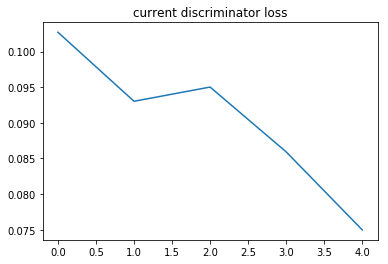

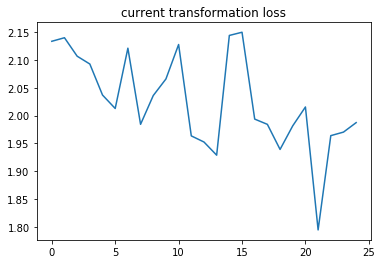

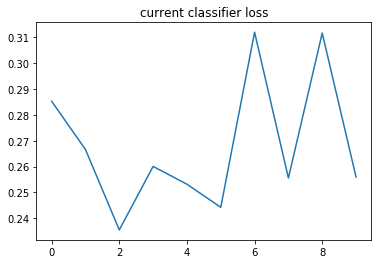

Iter 2499 class 0.2679916024208069, discr0.09032843261957169, transform 2.024996042251587


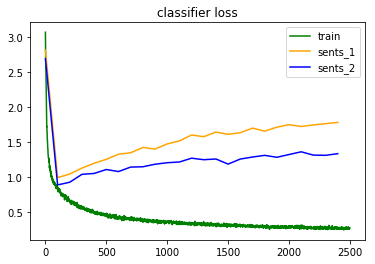

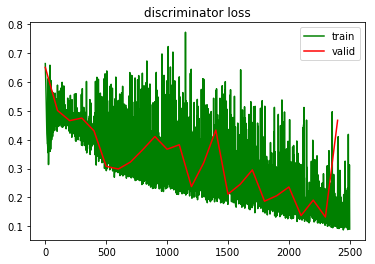

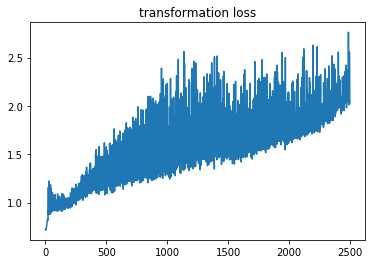

In [46]:
# trainer.t
trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

In [47]:
import pickle

In [49]:
trainer.model = None

In [50]:
pickle.dump((trainer, params), open("trainer.pkl", "wb"))

In [51]:
trainer.model = cls

In [52]:
# trainer = pickle.load(open("../trained_models/10000_iterations_fr_en_big_embeddings/trainer_10000_iterations_fr_en.pkl", "rb"))

In [53]:
w1 = cls.transformation_1.weight.data.cpu().numpy()

AttributeError: 'IdentityTransformation' object has no attribute 'weight'

In [54]:
!ls

1_with_classifier.pkl		model.py
__pycache__			model_checkpoint.tc
batch_samplers.py		model_checkpoint_sentences_2tc
data_processing.py		model_utilities.py
discriminator.py		model_utilities_rnn.py
discriminator_utilities.py	rnn_checkpoint.ckpt
embeds_1_tmp.vec		rnn_classifier.py
embeds_2_tmp.vec		rnn_classifier_dev_torch.ipynb
embeds_en.vec			rnn_classifier_torch.py
embeds_fr.vec			run_muse_validation.sh
evaluation.py			trainer.pkl
gan_debug.ipynb			validation.ipynb
gan_debug_neat.ipynb		vocab.py
gan_debug_with_sentences.ipynb	vocab_rnn.py


In [55]:
w2 = cls.transformation_2.weight.data.cpu().numpy()

In [56]:
np.all((w1.T @ w1).argmax(axis=1) == np.arange(w1.shape[0]))

NameError: name 'w1' is not defined

In [57]:
np.all((w2.T @ w2).argmax(axis=1) == np.arange(w2.shape[0]))

True

In [58]:
np.diag(w2 @ w2.T)

array([0.855277  , 0.8781329 , 0.7922186 , 0.84338474, 0.7921633 ,
       0.7475095 , 0.8048276 , 0.8227739 , 0.82473457, 0.7856454 ,
       0.8694839 , 0.8688958 , 0.7525279 , 0.80179656, 0.85820687,
       0.82034767, 0.9562251 , 0.9452991 , 0.79748225, 0.7578136 ,
       0.88943726, 0.7297316 , 0.8025933 , 0.9163899 , 0.69364667,
       0.8769683 , 0.8732154 , 0.77530307, 0.8124106 , 0.85076946,
       0.83093846, 0.7926609 , 0.8579886 , 0.77531904, 0.8036959 ,
       0.8651337 , 0.8574741 , 0.82001007, 0.8882062 , 0.9568231 ,
       0.8560197 , 0.85574293, 0.93066174, 0.9474435 , 0.77594525,
       0.8152391 , 0.92155033, 0.77489656, 0.8876611 , 0.8693663 ,
       0.8617326 , 0.7836804 , 0.96779794, 0.75353104, 0.78283405,
       0.7336929 , 0.8897641 , 0.85839564, 0.8604759 , 0.7660675 ,
       0.78035516, 0.83747923, 0.83582   , 0.8676461 , 0.9103959 ,
       0.892979  , 0.8238822 , 0.8197425 , 0.8472281 , 0.9451657 ,
       0.80385405, 0.9289206 , 0.8023823 , 0.8574482 , 0.85612

In [59]:
cls.discriminator.actual_model[0].bias.mean()

Variable containing:
-0.1971
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [60]:
# trainer.transformation_losses[-100:]

In [61]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [62]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [63]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
    
    result = np.vstack(result)
    z = 1 - result
    result = np.hstack([z, result])
    return result, np.vstack(embeds)

In [64]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [65]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    
    plt.legend()
    plt.show()
    

    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

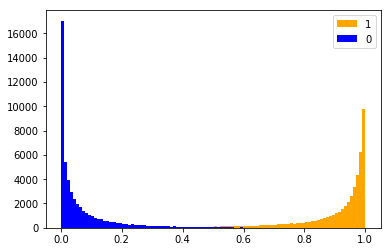

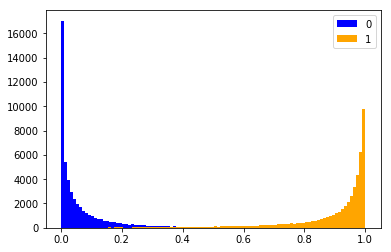

Accuracy  0.9750904981900362
Loss  0.10919914069422348
Confusion matrix
 [[49409.   592.]
 [ 1899. 48102.]]
Min component variance 0.830446183681488, median component variance 0.9182775020599365, mean component variance 0.9201542139053345, max c v 1.0366467237472534
Total length  100002


In [66]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print("Total length ", len(result[-1]))

In [67]:
# cls.discriminator.actual_model.zero_grad()

In [68]:
embeds = result[-1]

In [69]:
# embeds = normalize_embeddings(embeds)

In [70]:
embeds1 = embeds[:len(vocab1.embeddings)]
embeds2 = embeds[len(vocab1.embeddings):]

/data/itasarom/torch/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


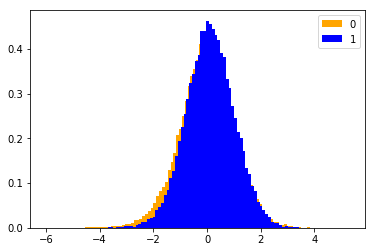

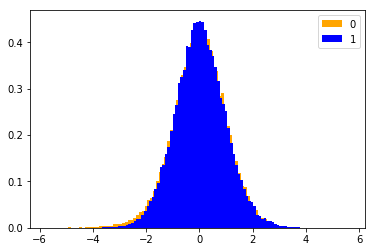

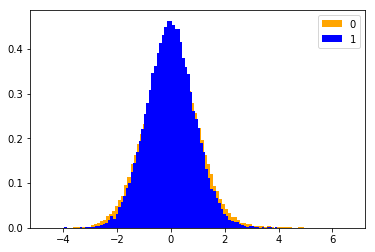

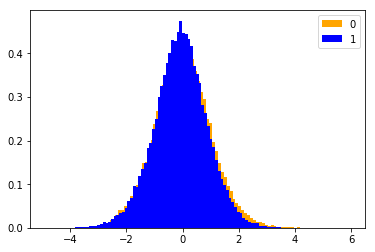

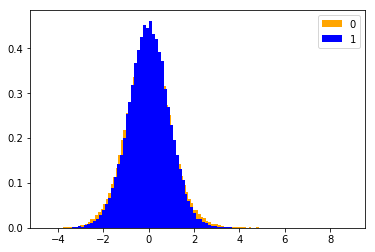

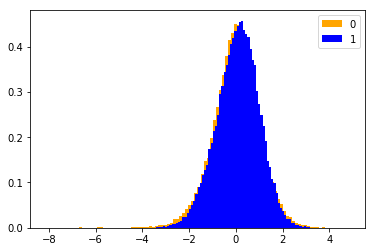

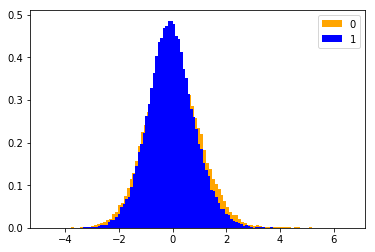

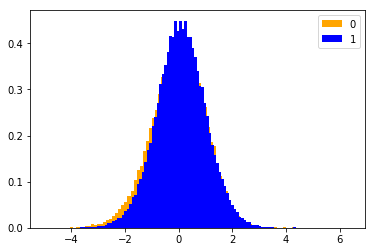

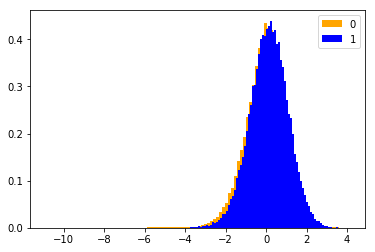

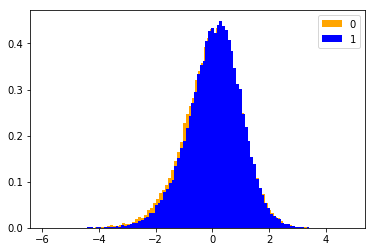

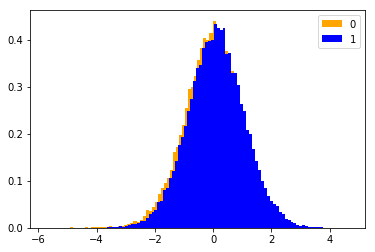

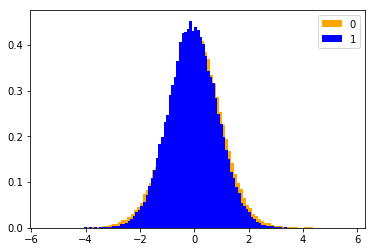

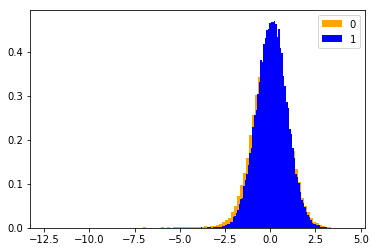

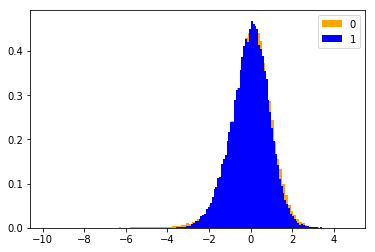

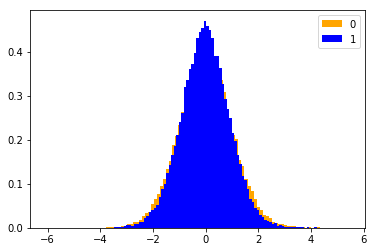

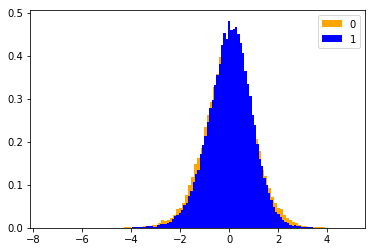

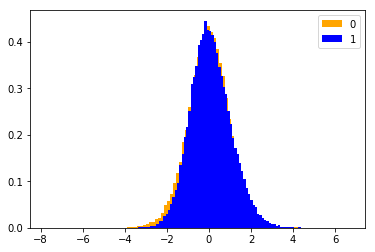

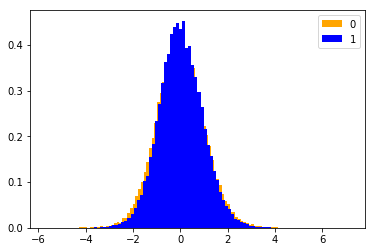

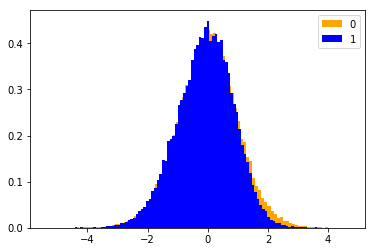

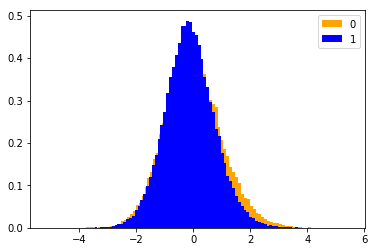

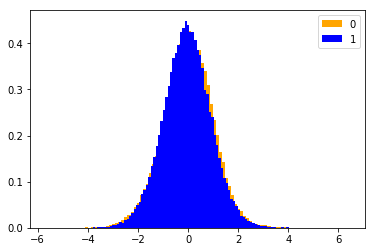

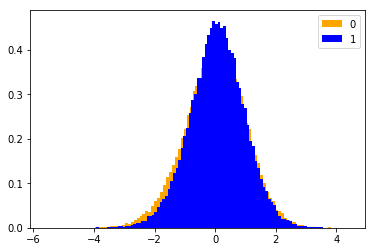

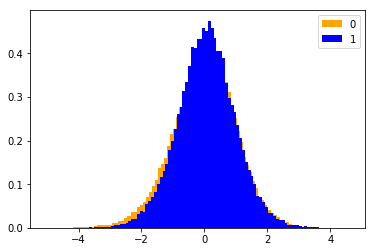

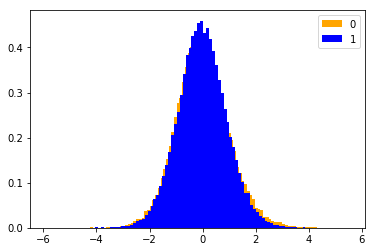

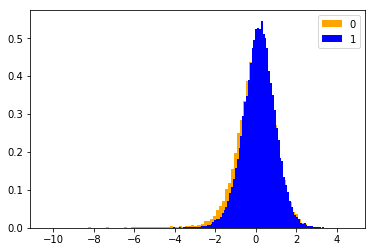

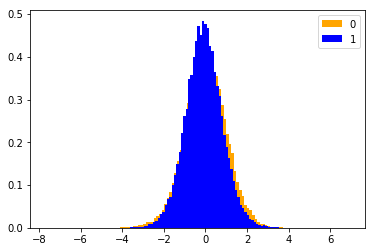

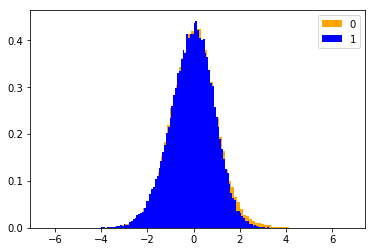

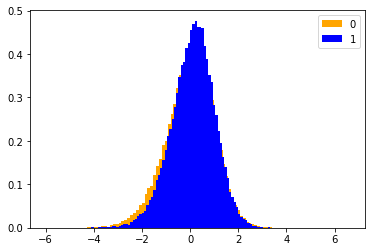

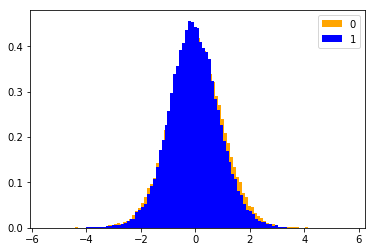

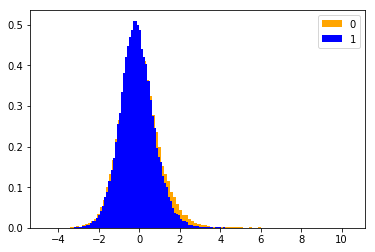

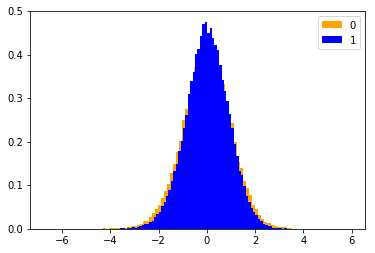

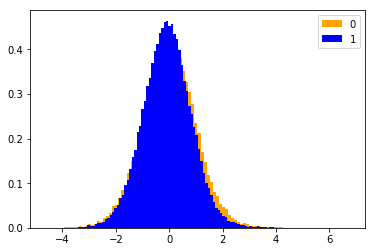

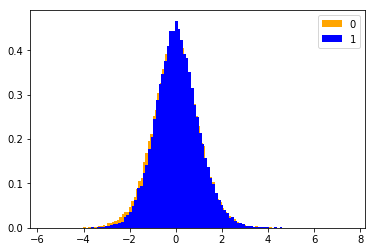

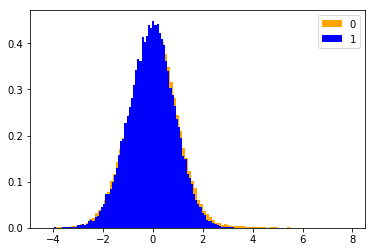

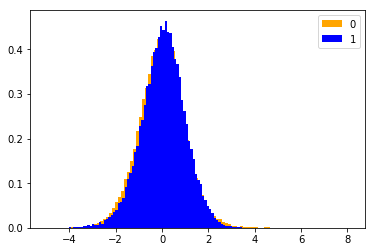

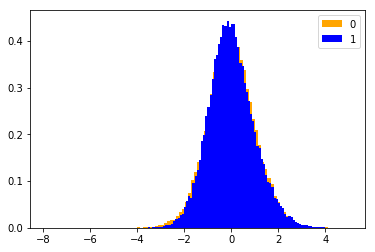

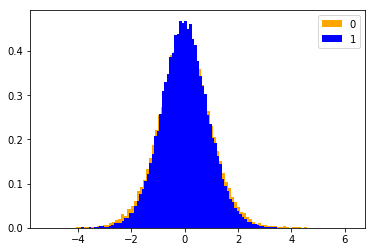

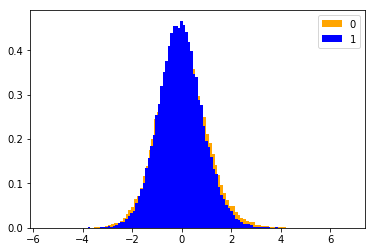

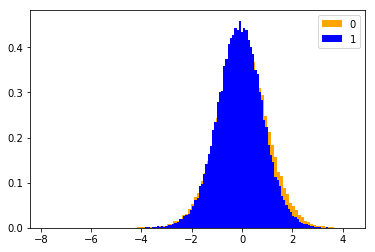

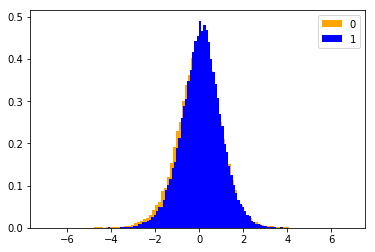

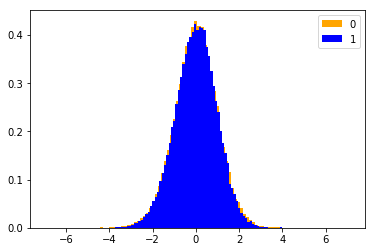

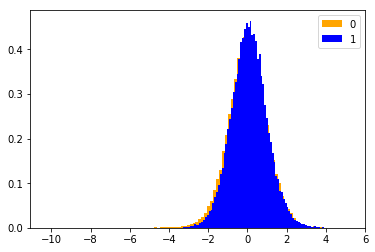

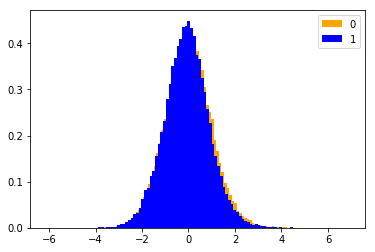

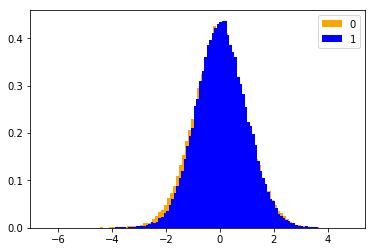

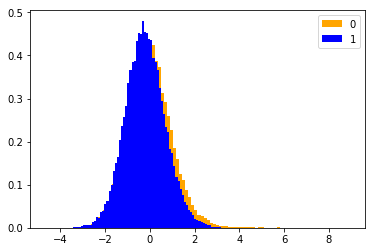

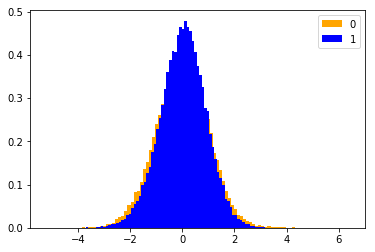

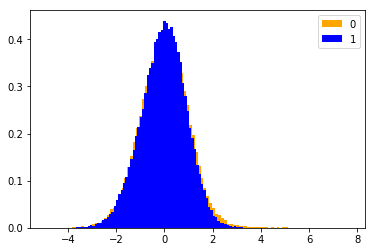

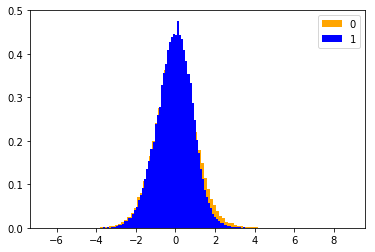

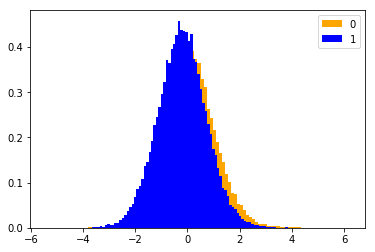

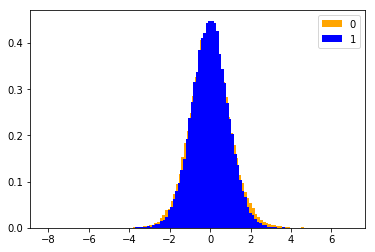

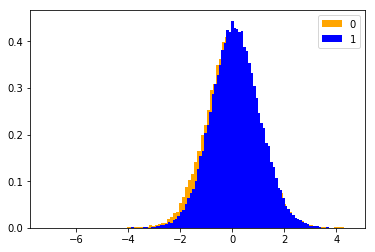

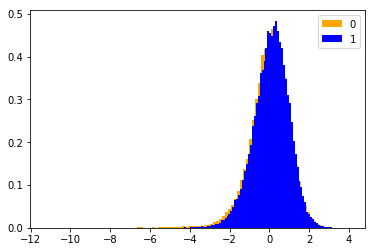

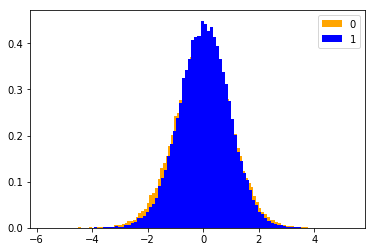

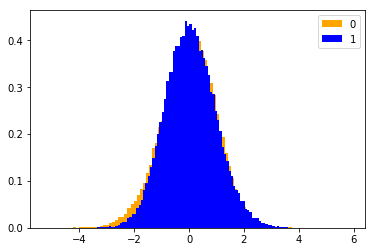

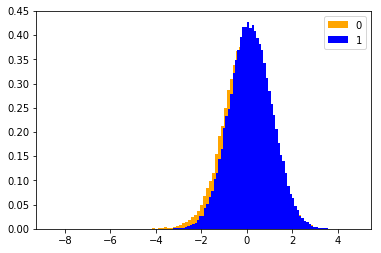

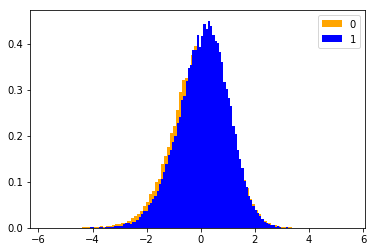

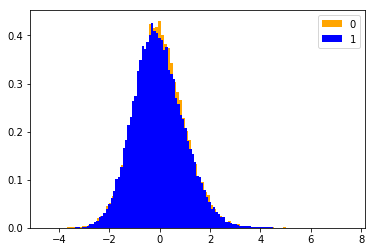

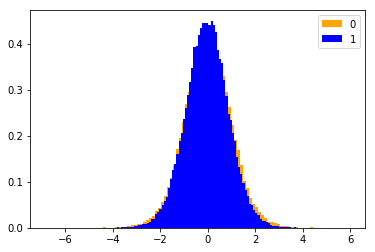

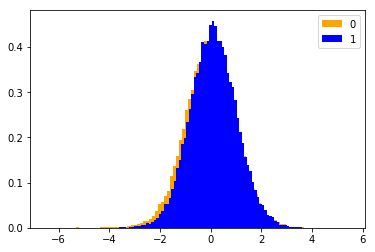

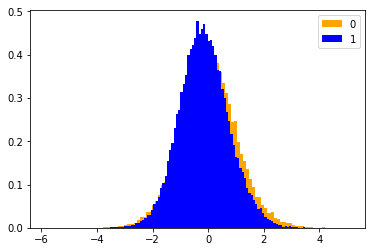

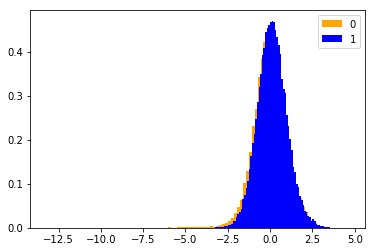

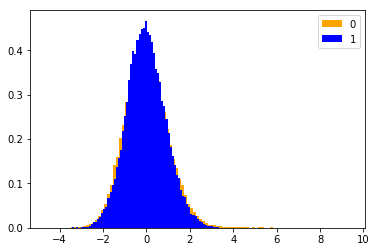

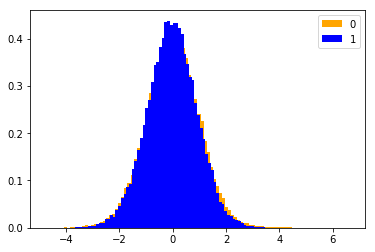

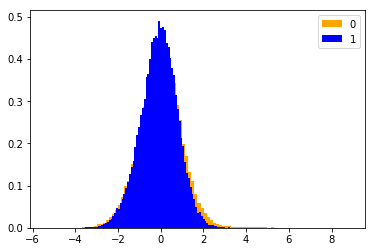

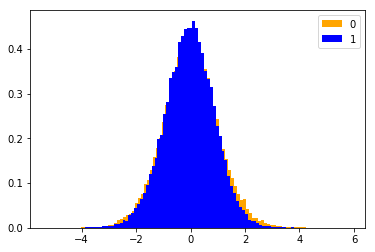

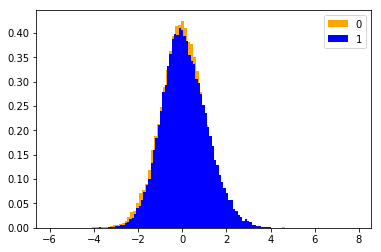

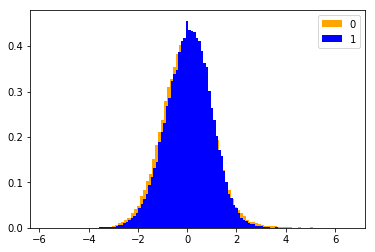

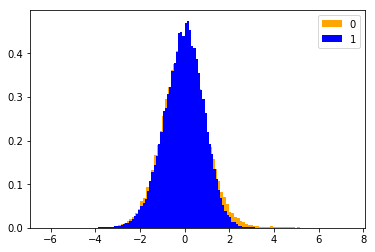

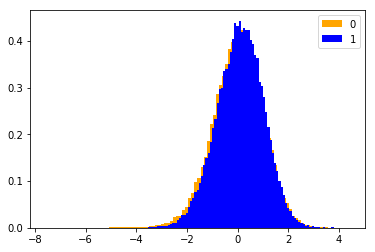

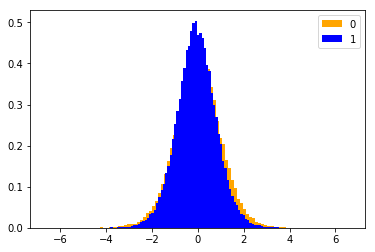

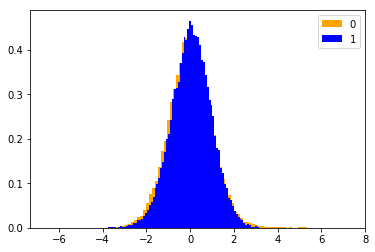

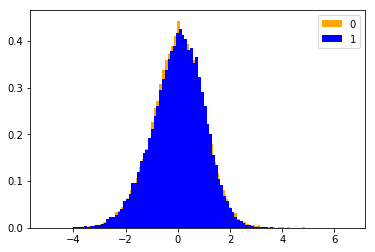

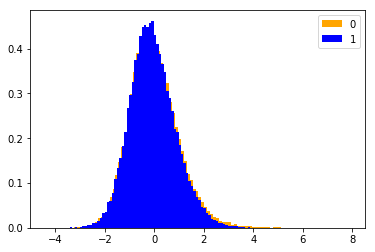

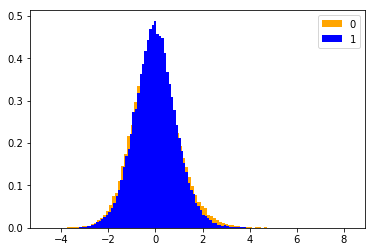

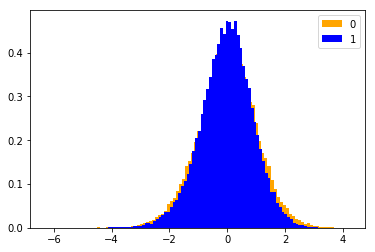

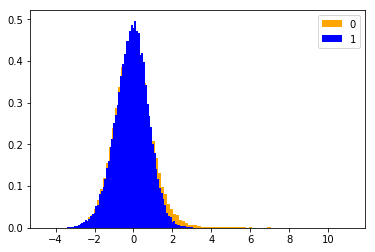

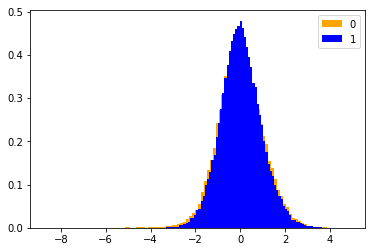

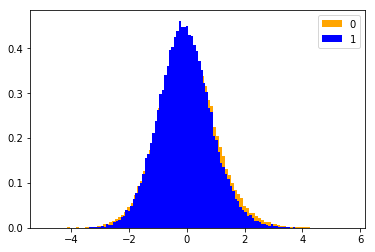

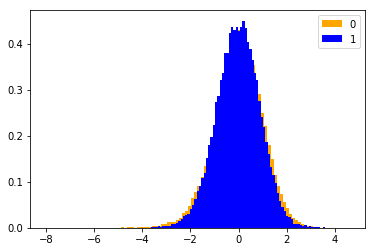

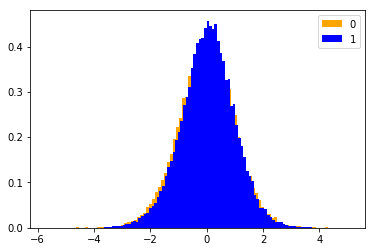

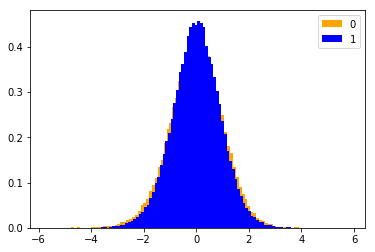

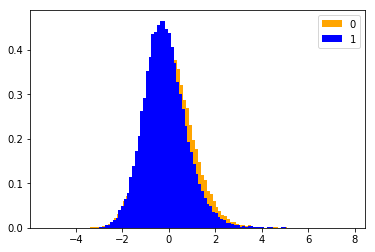

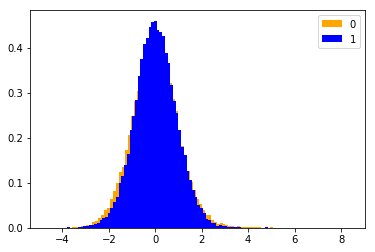

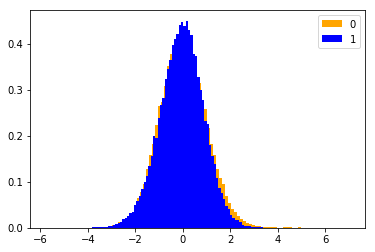

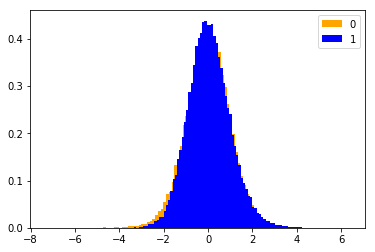

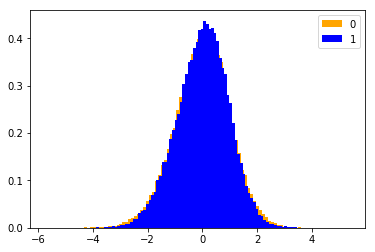

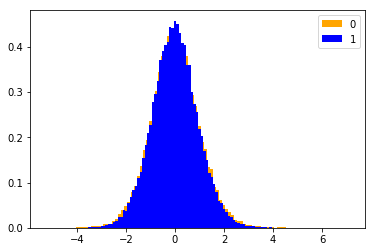

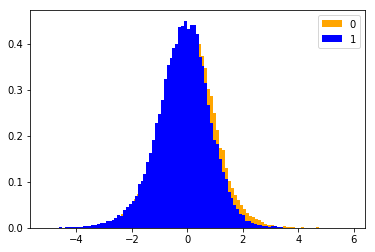

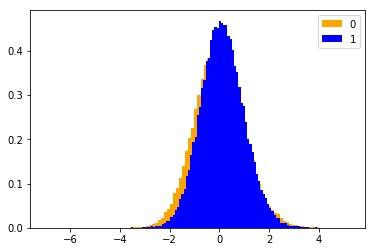

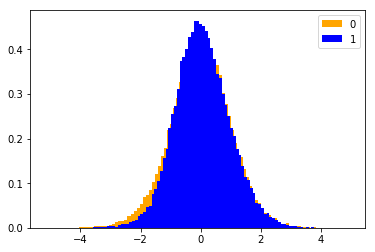

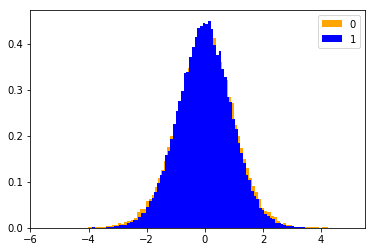

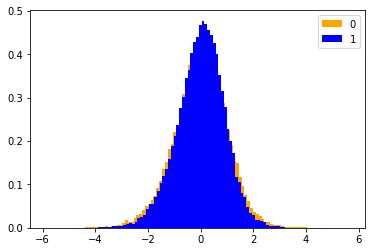

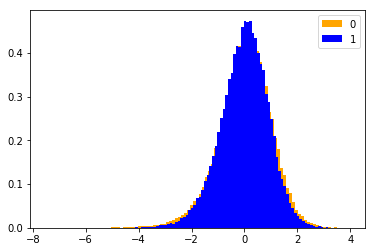

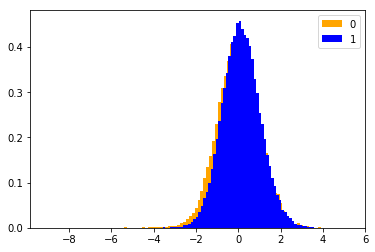

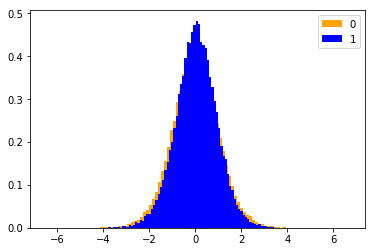

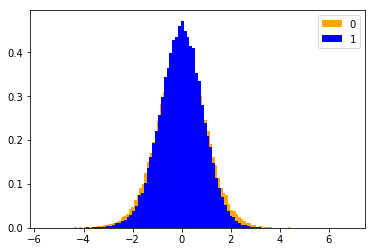

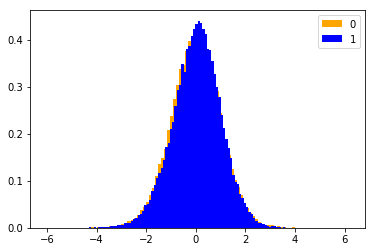

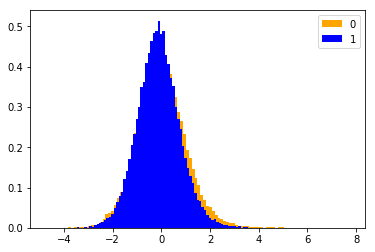

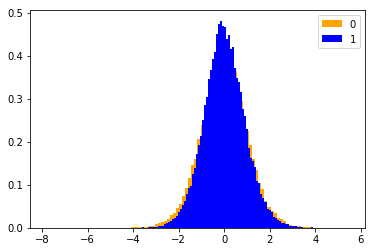

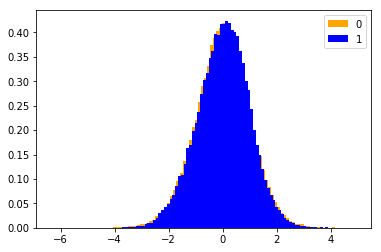

In [71]:
for i in range(100):
    plt.hist(embeds1[:, i], color='orange', bins=100, label='0', normed=True)
    plt.hist(embeds2[:, i], color='blue', bins=100, label='1', normed=True)
    plt.legend()
    plt.show()

In [72]:
import evaluation

In [73]:
def describe(sent_sampler, model, transformation):
    model.eval()
    x, mask, y = sent_sampler.get_test()
#     x, mask, y = sent_sampler.get_train_valid()
    true_y = np.zeros(shape=(len(y), len(sent_sampler.unique_labels)), dtype=np.int32)
    for idx, current_y in enumerate(y):
        true_y[idx, current_y] = 1
    
    x, mask, y = model.prepare_data_for_classifier(x, mask, y, transformation)
    
    if model.is_cuda:
        x = x.cuda()
        y = y.cuda()
        mask = mask.cuda()
    

    
    loss = model.classifier.get_loss(x, mask, y).data.cpu().numpy()
    probs = model.classifier(x, mask)[1].data.cpu().numpy()
    
    pred = np.argmax(probs, axis=1)
    
    acc = evaluation.accuracy(predicted_probs=probs, true_y=true_y)
    prec = {}
    rec = {}
    for cls in range(true_y.shape[1]):
        prec[cls] = evaluation.precision_by_class(probs, true_y, cls)
        rec[cls] = evaluation.recall_by_class(probs, true_y, cls)
    
    return acc, prec, rec, evaluation.build_confusion_matrix(probs, true_y)

    

In [74]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform1)

In [75]:
print(acc, len(sent_sampler_1.sents))

(689, 1024, 0.6728515625) 17860


In [76]:
print(acc, len(sent_sampler_1.sents))

(689, 1024, 0.6728515625) 17860


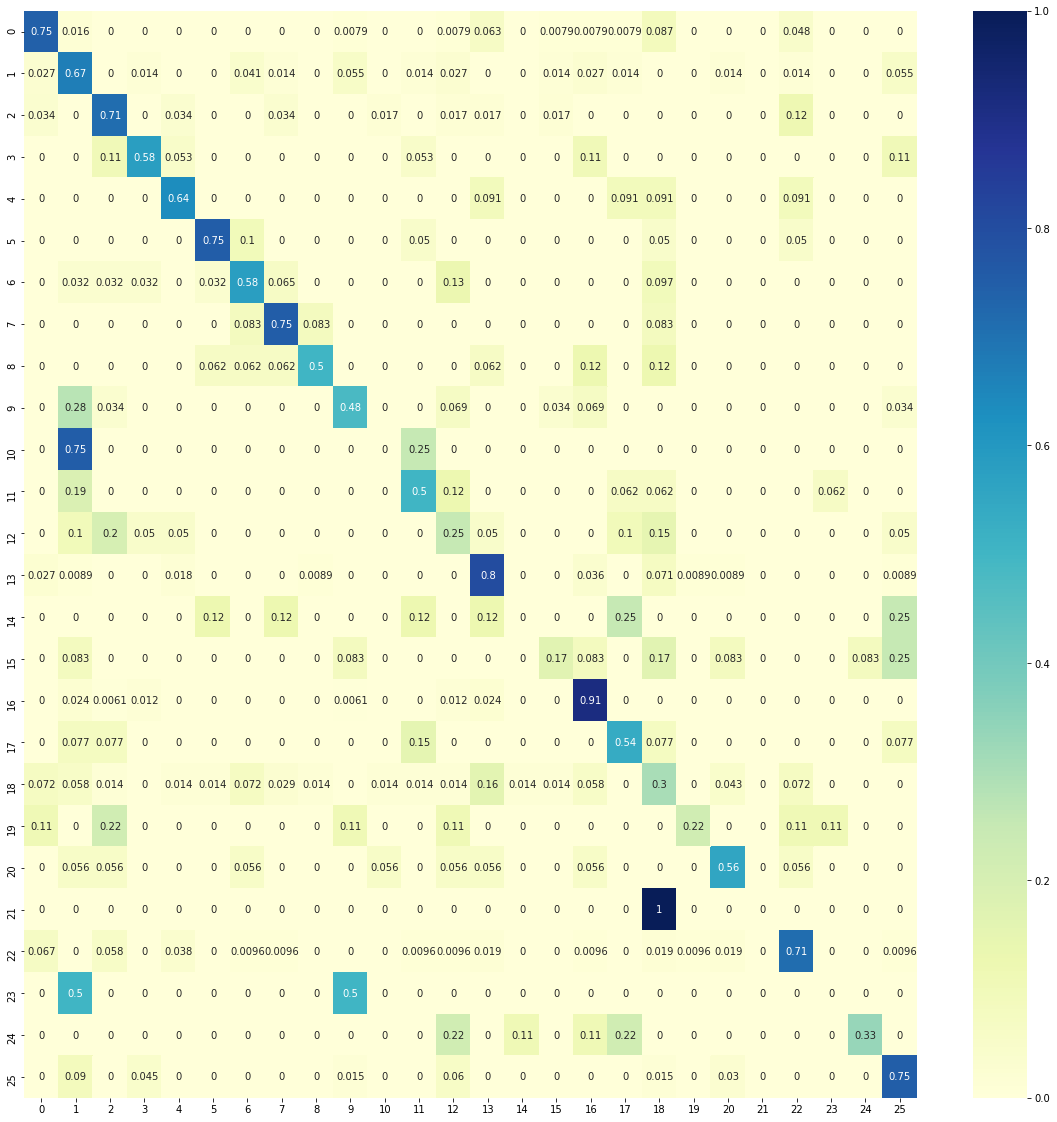

In [77]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [78]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_2, cls, cls.transform2)

In [79]:
print(acc, len(sent_sampler_2.sents))

(726, 1024, 0.708984375) 18641


In [80]:
print(acc, len(sent_sampler_2.sents))

(726, 1024, 0.708984375) 18641


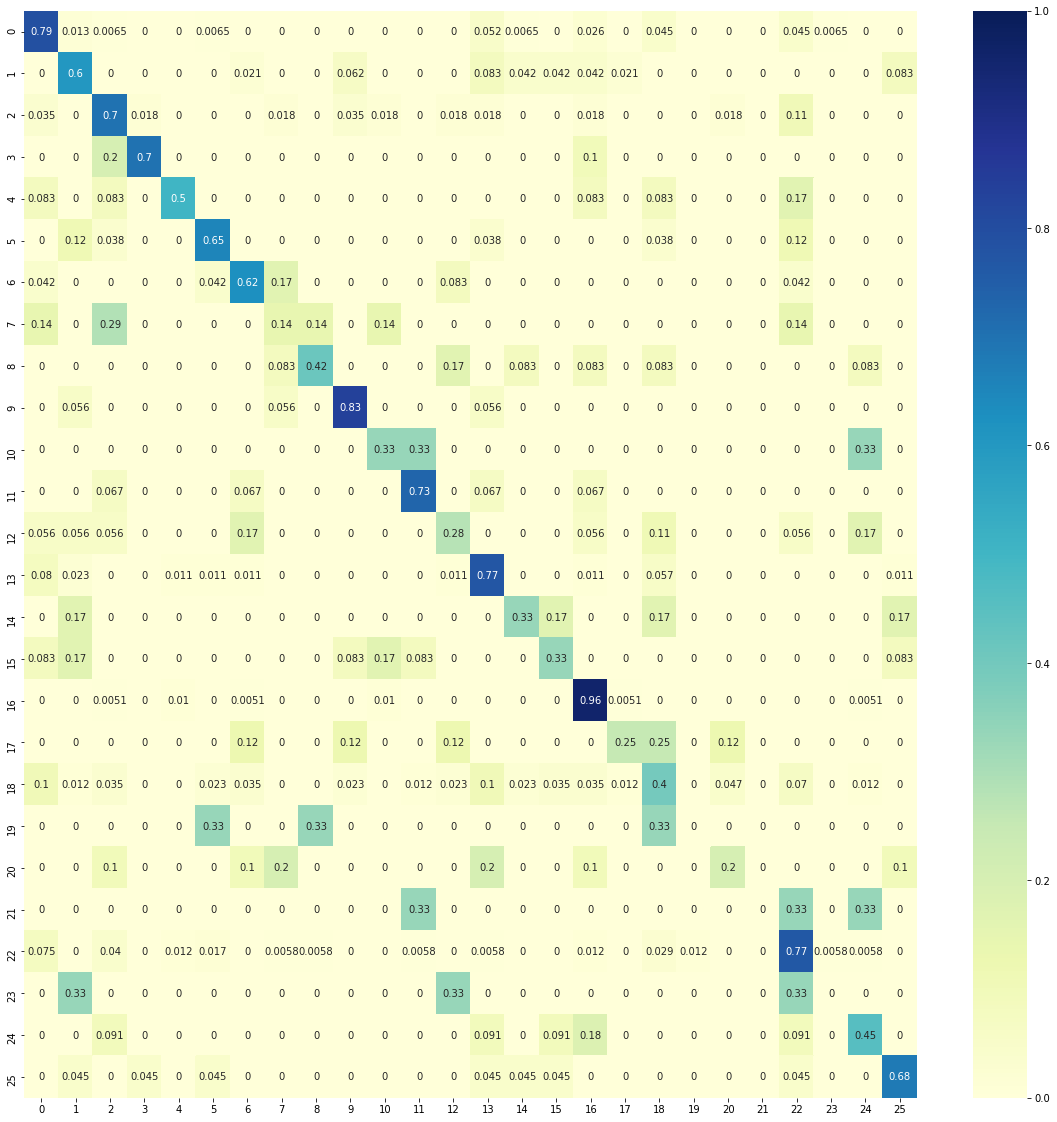

In [81]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [82]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform2)

In [83]:
acc

(50, 1024, 0.048828125)

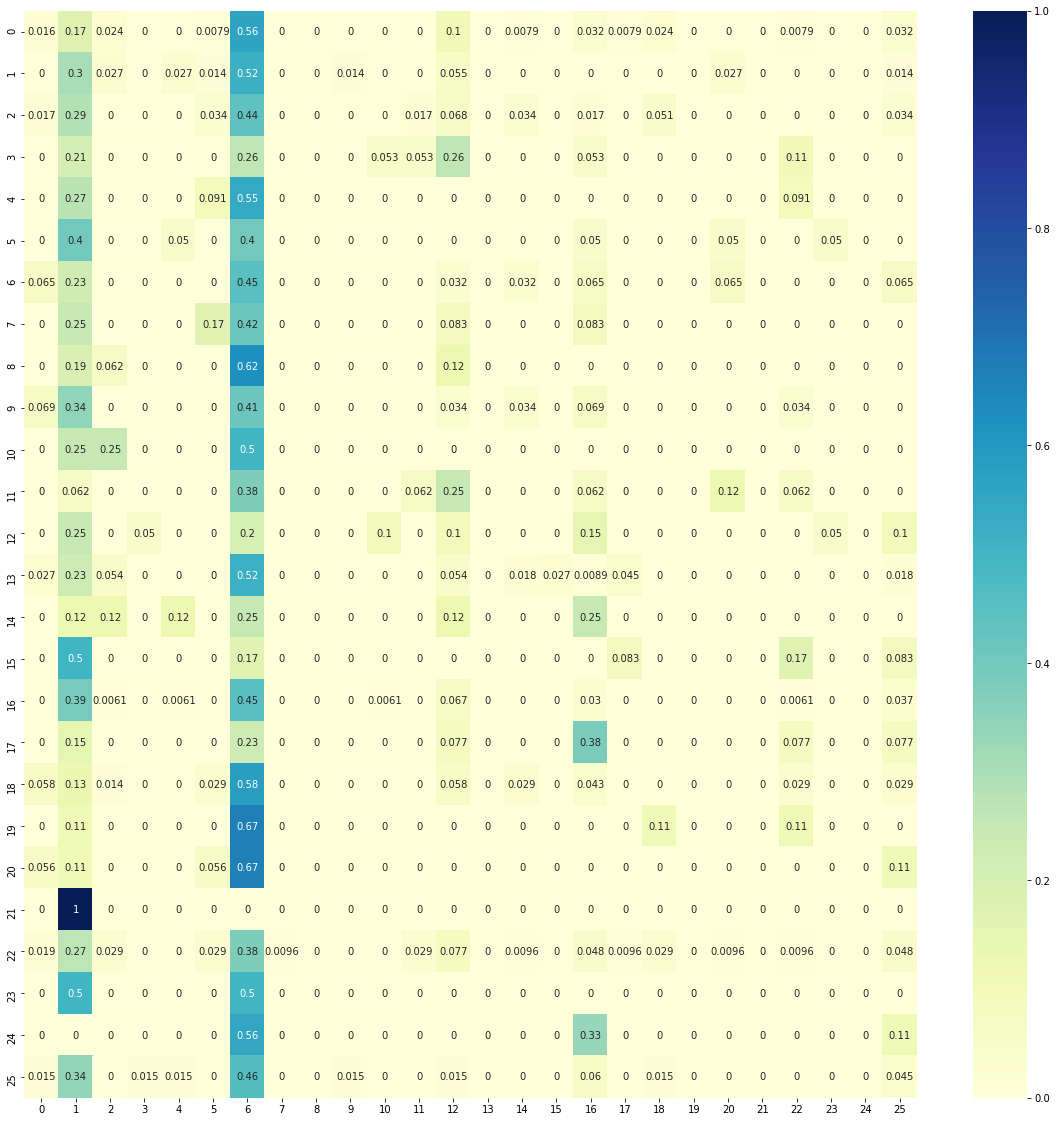

In [84]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [85]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, model.IdentityTransformation())

In [86]:
acc

(689, 1024, 0.6728515625)

In [87]:
f = """
aider
famille
groupe
regarder
posséder
président
haut
homme
venir
octobre
gros
chaque
chose
femme
trouver
publique
campagne
eau
gauche
bien
pays
jamais
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [88]:
# s ="""
# ayudar
# familia
# grupo
# mira
# poseer
# presidente
# alto
# hombre
# venir
# octubre
# grande
# cada
# cosa
# mujer
# encontrar
# público
# campaña
# agua
# izquierda
# bueno
# país
# nunca
# """

# s = [w.strip() for w in s.split("\n") if len(w) > 1]


s = """
help
family
group
look
own
president
high
man
come
october
big
every
thing
woman
find
public
campaign
water
left
good
country
never
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [90]:
s, f = f, s

In [89]:
# def plot_word_by_id(t1, t2, e, f, ids, dims):
#     plt.figure(figsize=(20, 20))
# #     plt.scatter(t1[ids, 0], t1[ids, 1], color='r')
# #     plt.scatter(t2[ids, 0], t2[ids, 1], color='b')
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     for id in ids:
#         plt.annotate(e[id], (t1[id, dims[0]], t1[id, dims[1]]), color='r', fontsize=15)
#         plt.annotate(f[id], (t2[id, dims[0]], t2[id, dims[1]]), color='b', fontsize=15)
# #     plt.annotate(e)
# #         print(id)
#     plt.show()

In [91]:
def get_point(id, embeds, dims):
    return embeds[id, dims[0]], embeds[id, dims[1]]

def plot_word_by_id(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, dims, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        if not hide_original:
            plt.annotate(w1, get_point(id, orig1, dims), color='black', fontsize=15)
            plt.annotate(w2, get_point(id, orig2, dims), color='grey', fontsize=15)
        plt.annotate(w1, get_point(id, t1, dims), color='r', fontsize=15)
        plt.annotate(w2, get_point(id, t2, dims), color='b', fontsize=15)

        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [92]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[1, 2], hide_original=True)

In [93]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[12, 49], hide_original=True)

In [94]:
# e = """
# help
# family
# group
# look
# own
# president
# high
# man
# come
# october
# big
# every
# thing
# woman
# find
# public
# campaign
# water
# left
# good
# country
# never
# """
# e = [w.strip() for w in e.split("\n") if len(w) > 1]

In [95]:
# f = """
# aider
# famille
# groupe
# regarder
# posséder
# président
# haut
# homme
# venir
# octobre
# gros
# chaque
# chose
# femme
# trouver
# publique
# campagne
# eau
# gauche
# bien
# pays
# jamais
# """
# f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [96]:
# cls = cls.cpu()
from sklearn.decomposition import PCA

In [97]:
def get_point_pca(id, embeds):
    return embeds[id, 0], embeds[id, 1]

def plot_words_pca(pca, vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = pca.transform(orig1[ind_1])
    orig2 = pca.transform(orig2[ind_2])
    t1 = pca.transform(t1[ind_1])
    t2 = pca.transform(t2[ind_2])
    
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        
        if not hide_original:
            plt.annotate(w1, get_point_pca(id, orig1), color='black', fontsize=15)
            plt.annotate(w2, get_point_pca(id, orig2), color='grey', fontsize=15)
        plt.annotate(w1, get_point_pca(id, t1), color='r', fontsize=15)
        plt.annotate(w2, get_point_pca(id, t2), color='b', fontsize=15)
        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [98]:
# pca1 = PCA(n_components=2)
# pca1.fit(vocab1.embeddings)

In [99]:
# pca2 = PCA(n_components=2)
# pca2.fit(vocab2.embeddings)

In [100]:
# pca3 = PCA(n_components=2)
# pca3.fit(embeds1)

In [101]:
# pca4 = PCA(n_components=2)
# pca4.fit(embeds2)

In [102]:
pca = PCA(n_components=2)
# pca.fit(np.vstack([embeds1, embeds2]))
pca.fit(np.vstack([embeds2]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

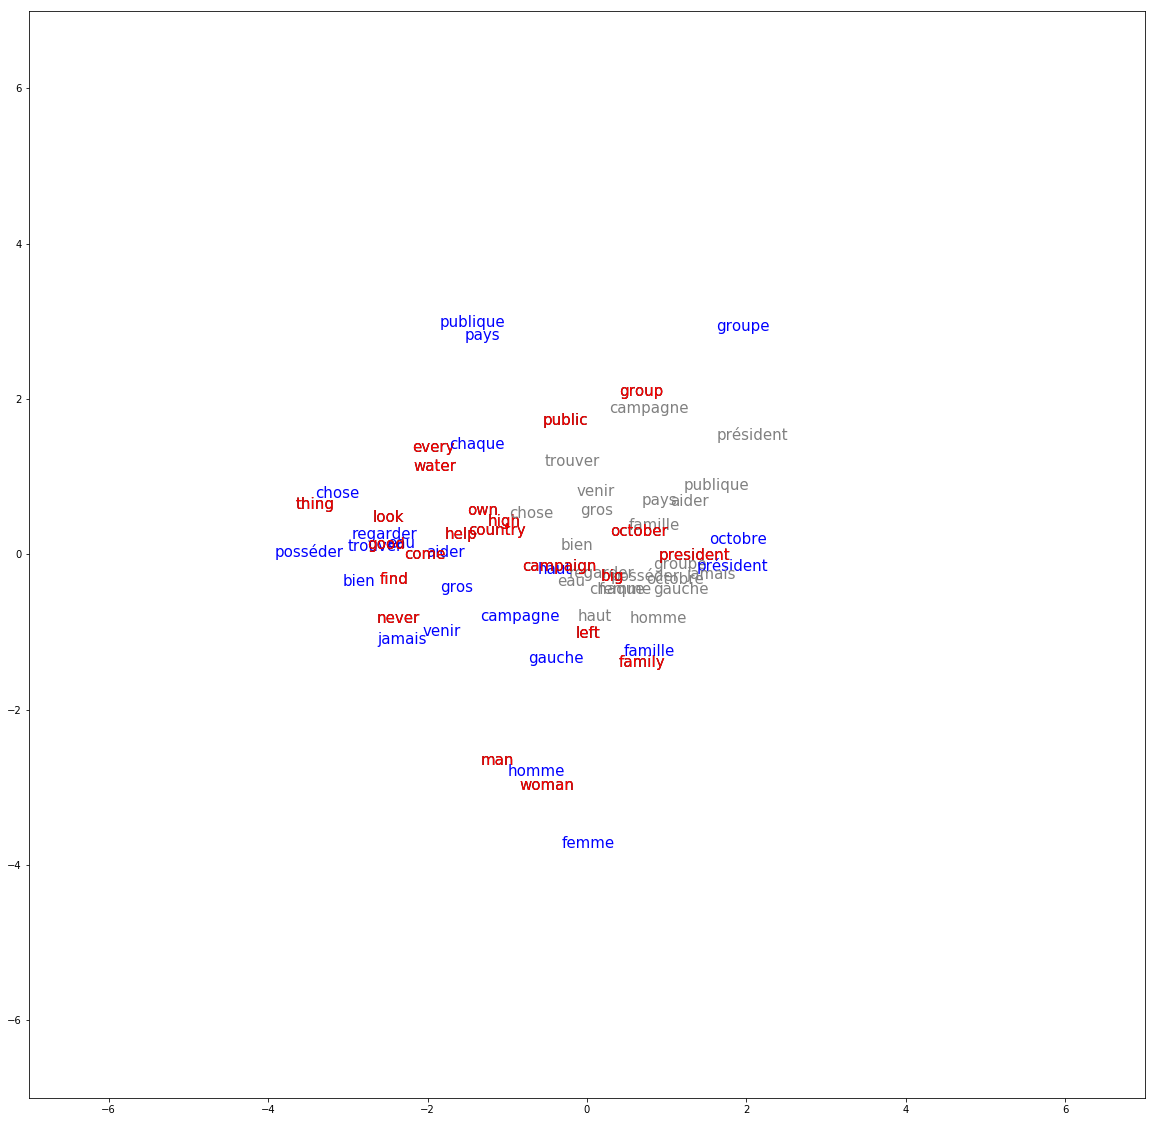

In [103]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=False)

In [104]:
from sklearn.metrics.pairwise import cosine_similarity

In [105]:
import seaborn as sns

In [106]:
# f

In [107]:
def cos(a, b):
    a = a/(a**2).sum(axis=1, keepdims=True)**0.5
    b = b/(b**2).sum(axis=1, keepdims=True)**0.5
    
    return (a * b).sum(axis=1)

def cosine_metrics(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    before = cos(orig1, orig2)
    after = cos(t1, t2)
    
    print("{}|{}|{}|{}".format("lang1", "lang2", "before", "after", fill=' ', align='<', width=10))
    for w1, w2, c1, c2 in zip(lang_1, lang_2, before, after):
        print("{}|{}|{:.4f}|{:.4f}".format(w1, w2, c1, c2, fill=' ', align='<', width=10))
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    plt.figure(figsize=(15, 15))
    sns.heatmap(c1, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2 - c1)
    plt.show()
    
#     print(t1.shape, t2.shape)
#     print(c2.shape)
    s = 0
    for id, w1 in enumerate(lang_1):
#         print(c2[id].argmax())
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        s += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(s/len(lang_1))
#     plt.figure(figsize=(15, 15))
#     sns.heatmap((c2 - c1 > 0.1).astype(np.float32))
#     plt.show()
#     print(np.diag(c2))
#     print(np.diag(c1))
#     print()


In [108]:

def word_translation_cosine(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    
    count = 0
    for id, w1 in enumerate(lang_1):
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(count/len(lang_1))
    
    count = 0
    for id, w2 in enumerate(lang_2):
        translation = lang_1[c2[:, id].argmax()]
        if translation == lang_1[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_1[id]
        print("{} --> {} ({})".format(w2, translation, res))
        
    print(count/len(lang_2))



In [109]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

help --> aider (OK)
family --> famille (OK)
group --> groupe (OK)
look --> regarder (OK)
own --> posséder (OK)
president --> président (OK)
high --> haut (OK)
man --> homme (OK)
come --> venir (OK)
october --> octobre (OK)
big --> gros (OK)
every --> chaque (OK)
thing --> chose (OK)
woman --> femme (OK)
find --> trouver (OK)
public --> publique (OK)
campaign --> campagne (OK)
water --> eau (OK)
left --> gauche (OK)
good --> chose (Fail)
country --> pays (OK)
never --> jamais (OK)
0.9545454545454546
aider --> help (OK)
famille --> family (OK)
groupe --> group (OK)
regarder --> look (OK)
posséder --> never (Fail)
président --> president (OK)
haut --> high (OK)
homme --> man (OK)
venir --> come (OK)
octobre --> october (OK)
gros --> big (OK)
chaque --> every (OK)
chose --> thing (OK)
femme --> woman (OK)
trouver --> find (OK)
publique --> public (OK)
campagne --> campaign (OK)
eau --> water (OK)
gauche --> left (OK)
bien --> never (Fail)
pays --> country (OK)
jamais --> never (OK)
0.90909

lang1|lang2|before|after
help|aider|-0.0419|0.5990
family|famille|0.0673|0.6728
group|groupe|0.0382|0.5233
look|regarder|-0.1492|0.4623
own|posséder|0.0321|0.1972
president|président|0.0006|0.6127
high|haut|-0.0602|0.2531
man|homme|0.0609|0.4327
come|venir|-0.0472|0.3986
october|octobre|-0.0121|0.4310
big|gros|0.0827|0.3216
every|chaque|-0.1211|0.4005
thing|chose|0.0445|0.5669
woman|femme|-0.0036|0.6144
find|trouver|-0.0666|0.6545
public|publique|0.0742|0.4563
campaign|campagne|-0.0446|0.4798
water|eau|0.0463|0.6904
left|gauche|0.0086|0.3756
good|bien|-0.0314|0.2584
country|pays|-0.0874|0.2726
never|jamais|-0.0665|0.5752


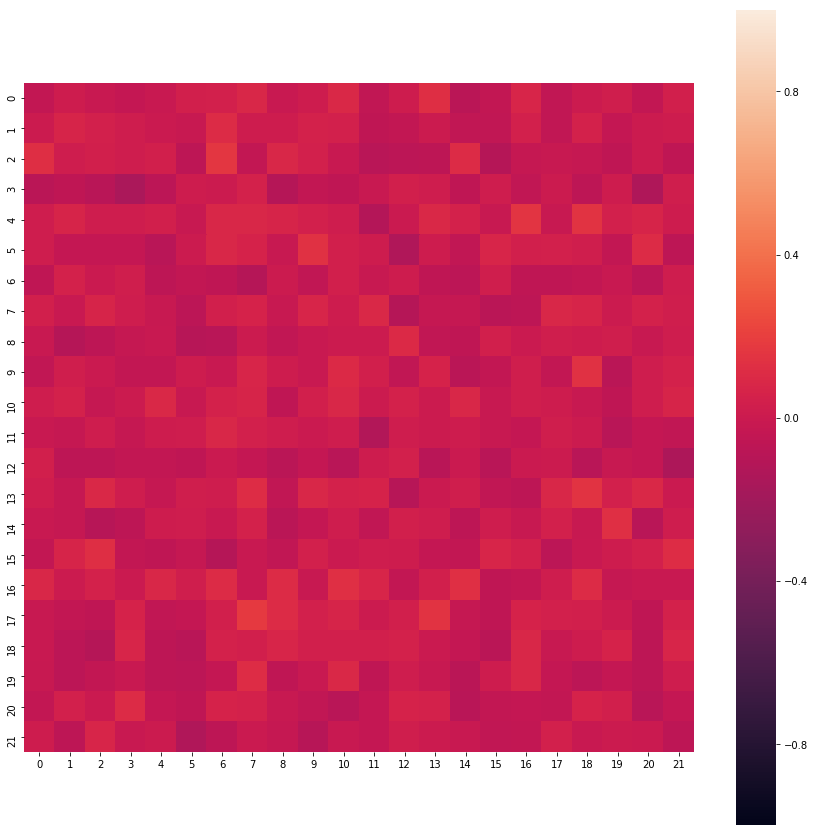

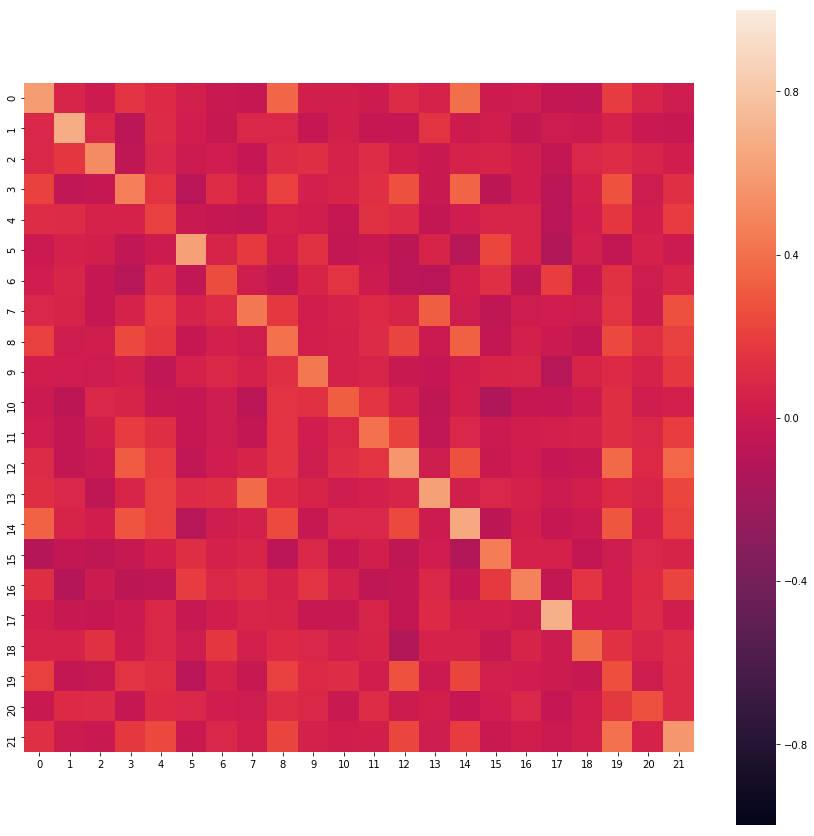

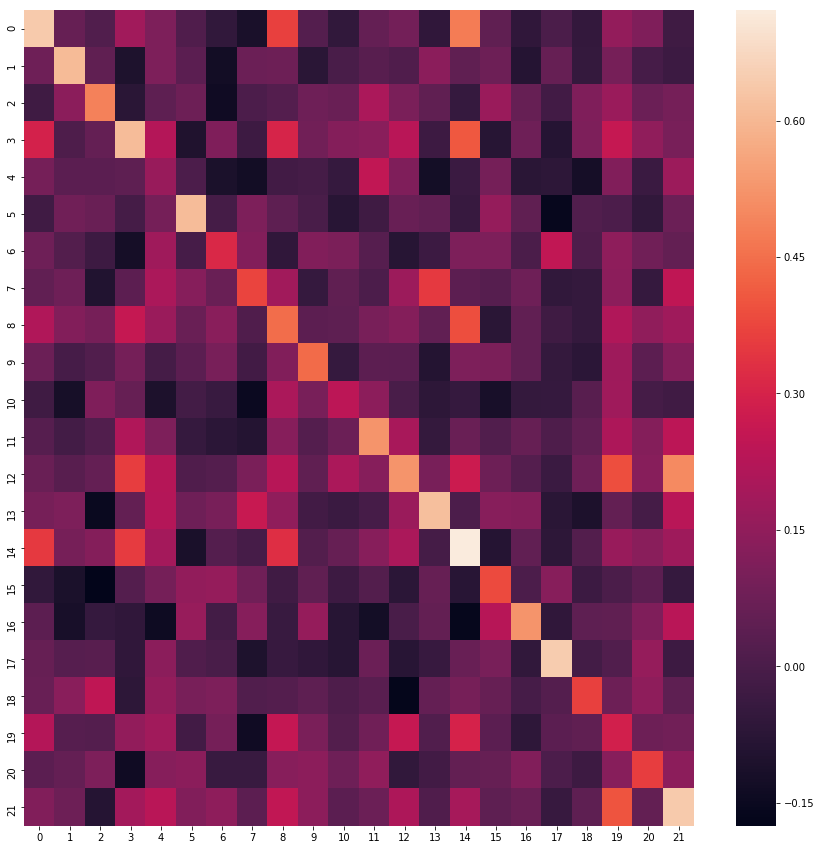

help --> aider (OK)
family --> famille (OK)
group --> groupe (OK)
look --> regarder (OK)
own --> posséder (OK)
president --> président (OK)
high --> haut (OK)
man --> homme (OK)
come --> venir (OK)
october --> octobre (OK)
big --> gros (OK)
every --> chaque (OK)
thing --> chose (OK)
woman --> femme (OK)
find --> trouver (OK)
public --> publique (OK)
campaign --> campagne (OK)
water --> eau (OK)
left --> gauche (OK)
good --> chose (Fail)
country --> pays (OK)
never --> jamais (OK)
0.9545454545454546


In [110]:
cosine_metrics(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

In [111]:
# vocab1.transformation

In [112]:
import os
def read_facebook_dict(path, file_name, vocab1, vocab2):
    path = os.path.join(path, file_name)
    
    lang_1 = []
    lang_2 = []
    with open(path, "r") as f:
        for line in f:
            a, b = line.strip().split(" ")
            if a in vocab1.transformation and b in vocab2.transformation:
                lang_1.append(a)
                lang_2.append(b)
                
    return lang_1, lang_2

In [113]:
def word_translation_cosine_silent(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity = cosine_similarity(t1, t2)
    else:
        similarity = cosine_similarity(orig1, orig2)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        candidate_ids = (-similarity[id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        candidate_ids = (-similarity[:, id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [114]:
word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

({1: 0.9545454545454546,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0},
 {1: 0.9090909090909091,
  2: 0.9090909090909091,
  3: 0.9545454545454546,
  4: 0.9545454545454546,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0})

In [115]:
lang_1, lang_2 = read_facebook_dict("../crosslingual/dictionaries/", "en-fr.5000-6500.txt", vocab1, vocab2)

In [116]:
# word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

In [117]:
def word_translation_cosine_complete(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    orig1_complete = orig1
    orig2_complete = orig2
    t1_complete = t1
    t2_complete = t2
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity_1_2 = cosine_similarity(t1, t2_complete)
        similarity_2_1 = cosine_similarity(t2, t1_complete)
    else:
        similarity_1_2 = cosine_similarity(orig1, orig2_complete)
        similarity_2_1 = cosine_similarity(orig2, orig1_complete)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        translation_id = vocab2.words.index(lang_2[id])
        candidate_ids = (-similarity_1_2[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        translation_id = vocab1.words.index(lang_1[id])
        candidate_ids = (-similarity_2_1[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [118]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=False)

({1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  50: 0.0003700962250185048,
  100: 0.0003700962250185048,
  200: 0.0033308660251665434,
  500: 0.009252405625462621,
  1000: 0.01998519615099926,
  2000: 0.04145077720207254,
  5000: 0.10103626943005181,
  10000: 0.2068837897853442,
  20000: 0.40340488527017027,
  50000: 1.0},
 {1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  50: 0.0003700962250185048,
  100: 0.0007401924500370096,
  200: 0.0029607698001480384,
  500: 0.009622501850481125,
  1000: 0.01924500370096225,
  2000: 0.04293116210214656,
  5000: 0.10251665433012583,
  10000: 0.20947446336047373,
  20000: 0.4078460399703923,
  50000: 1.0})

In [119]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.34381939304219095,
  2: 0.4859363434492968,
  3: 0.5569948186528497,
  4: 0.6043671354552184,
  5: 0.6310140636565507,
  6: 0.6502590673575129,
  7: 0.6743153219837158,
  8: 0.6876387860843819,
  9: 0.698741672834937,
  10: 0.7076239822353811,
  50: 0.8275351591413768,
  100: 0.8719467061435974,
  200: 0.9056254626202813,
  500: 0.9467061435973353,
  1000: 0.96039970392302,
  2000: 0.9755736491487786,
  5000: 0.9885270170244264,
  10000: 0.9940784603997039,
  20000: 0.9985196150999259,
  50000: 1.0},
 {1: 0.4100666173205033,
  2: 0.5247964470762398,
  3: 0.5891931902294597,
  4: 0.619541080680977,
  5: 0.6454478164322723,
  6: 0.6658031088082902,
  7: 0.6765358993338267,
  8: 0.6887490747594375,
  9: 0.6972612879348631,
  10: 0.7061435973353072,
  50: 0.8260547742413027,
  100: 0.8689859363434493,
  200: 0.9034048852701703,
  500: 0.9400444115470022,
  1000: 0.9592894152479645,
  2000: 0.9737231680236862,
  5000: 0.9896373056994818,
  10000: 0.9940784603997039,
  20000: 0.998519

In [121]:
#dp.write_embeds("./embeds_fr.vec", embeds1, vocab1.words)

In [120]:
#dp.write_embeds("./embeds_en.vec", embeds2, vocab2.words)

In [213]:
s = """
january
february
march
april
may
june
july
august
september
october
november
december
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [214]:
f = """
janvier
février
mars
avril
mai
juin
juillet
aout
septembre
octobre
novembre
décembre
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [215]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.08333333333333333,
  2: 0.16666666666666666,
  3: 0.4166666666666667,
  4: 0.4166666666666667,
  5: 0.5,
  6: 0.6666666666666666,
  7: 0.8333333333333334,
  8: 0.9166666666666666,
  9: 0.9166666666666666,
  10: 0.9166666666666666,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0,
  5000: 1.0,
  10000: 1.0,
  20000: 1.0,
  50000: 1.0},
 {1: 0.0,
  2: 0.16666666666666666,
  3: 0.3333333333333333,
  4: 0.3333333333333333,
  5: 0.4166666666666667,
  6: 0.6666666666666666,
  7: 0.75,
  8: 0.75,
  9: 0.75,
  10: 0.75,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0,
  5000: 1.0,
  10000: 1.0,
  20000: 1.0,
  50000: 1.0})

In [217]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

janvier --> april (Fail)
février --> june (Fail)
mars --> june (Fail)
avril --> june (Fail)
mai --> june (Fail)
juin --> june (OK)
juillet --> june (Fail)
aout --> june (Fail)
septembre --> june (Fail)
octobre --> june (Fail)
novembre --> june (Fail)
décembre --> april (Fail)
0.08333333333333333
january --> janvier (OK)
february --> septembre (Fail)
march --> septembre (Fail)
april --> septembre (Fail)
may --> septembre (Fail)
june --> septembre (Fail)
july --> septembre (Fail)
august --> septembre (Fail)
september --> septembre (OK)
october --> septembre (Fail)
november --> septembre (Fail)
december --> septembre (Fail)
0.16666666666666666


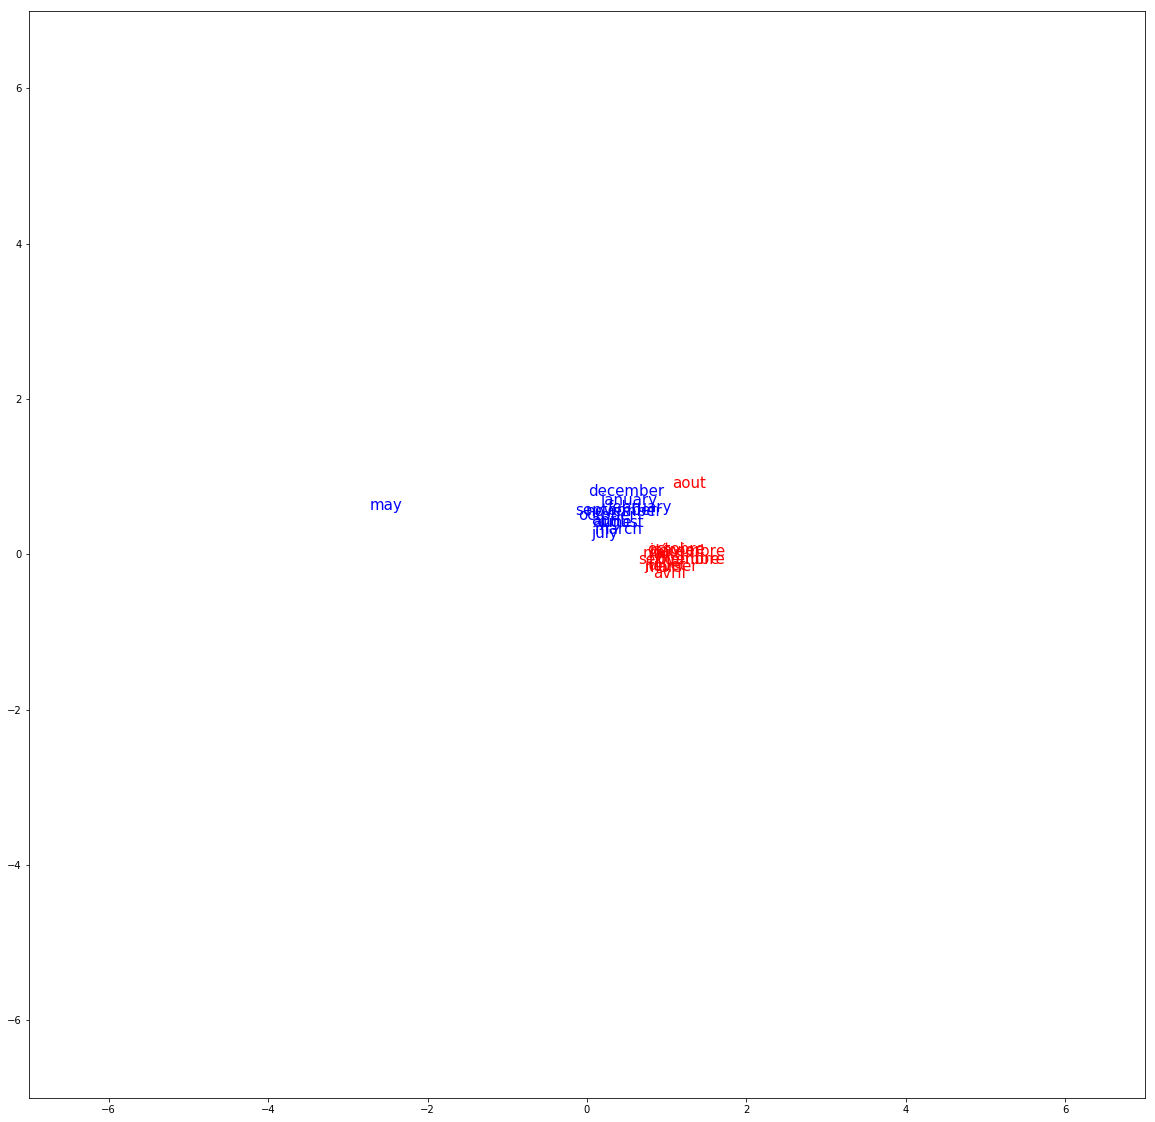

In [218]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=True)